# Classification

In [1]:
import keras
import tensorflow as tf
import numpy as np
from keras import layers

import json
import pandas as pd

import os
import time
os.environ["KERAS_BACKEND"] = "tensorflow"



import sklearn.naive_bayes as naive_bayes

import sklearn.linear_model as linear_model
from sklearn.metrics import accuracy_score


## Pre-Processing

In [2]:
def GetTagIdDictionary(fullDatasetFileLocation):
    with open(fullDatasetFileLocation, 'r', encoding='utf-8') as f:
        fullDataset = json.load(f)
    
    uniqueTags = {'O': 0}
    
    i = 1
    for datapoint in fullDataset:
        for sentence in datapoint['sentences']:
            for variableName in sentence['variables'].keys():
                if variableName not in uniqueTags:
                    uniqueTags[variableName] = i
                    i+=1

    return uniqueTags

def ReverseKeyValuePairing(dictionary):
    reversedDictionary = {}
    for key in dictionary.keys():
        reversedDictionary[dictionary[key]] = key
        
    return reversedDictionary

tagToIdDictionary = GetTagIdDictionary("sources/atis.json")
idToTagDictionary = ReverseKeyValuePairing(tagToIdDictionary)
print(tagToIdDictionary)

{'O': 0, 'airport_code0': 1, 'city_name0': 2, 'day_number0': 3, 'month_number0': 4, 'year0': 5, 'city_name1': 6, 'round_trip_required0': 7, 'airline_code0': 8, 'day_name0': 9, 'state_code0': 10, 'city_name2': 11, 'arrival_time0': 12, 'departure_time0': 13, 'day_number1': 14, 'stops0': 15, 'aircraft_code0': 16, 'meal_code0': 17, 'time_elapsed0': 18, 'state_name0': 19, 'class_type0': 20, 'city_name3': 21, 'transport_type0': 22, 'departure_time1': 23, 'flight_number0': 24, 'economy0': 25, 'booking_class0': 26, 'fare_basis_code0': 27, 'round_trip_cost0': 28, 'departure_time2': 29, 'departure_time3': 30, 'meal_description0': 31, 'airline_code1': 32, 'day_name1': 33, 'day_name2': 34, 'day_name3': 35, 'day_name4': 36, 'basic_type0': 37, 'manufacturer0': 38, 'arrival_time1': 39, 'days_code0': 40, 'connections0': 41, 'arrival_time2': 42, 'restriction_code0': 43, 'flight_days0': 44, 'airline_name0': 45, 'state_name1': 46, 'airport_code1': 47, 'airline_code2': 48, 'one_direction_cost0': 49, 'coun

### Define Datasets class

In [3]:
class Datasets:
    def __init__(self, trainingData, testingData, validationData):
        self.sqlTemplateToIds = self.GetUniqueSqlTemplatesFromTrainingSet(trainingData)
        self.sqlIdToTemplates = ReverseKeyValuePairing(self.sqlTemplateToIds)
        self.sqlIdToTemplates[0] = " "
        self.defaultTagValues = self.GetDefaultValues(trainingData)
        self.AddIdColumns([trainingData, testingData, validationData])
        
        self.trainingData = pd.DataFrame(trainingData)
        self.testingData = pd.DataFrame(testingData)
        self.validationData = pd.DataFrame(validationData)
        print(trainingData[1000])
    
    def GetUniqueSqlTemplatesFromTrainingSet(self, trainingData):
        uniqueTemplates = {}
        i = 1
        for datapoint in trainingData:
            template = datapoint['sql-template']
            if template not in uniqueTemplates:
                uniqueTemplates[template] = i
                i+=1
                
        return uniqueTemplates
    
    def ReverseKeyValuePairing(self, dictionary):
        reversedDict = {}
        for key in dictionary.keys():
            reversedDict[dictionary[key]] = key
        
        return reversedDict
    
    def AddIdColumns(self, datasetsList):
        for dataset in datasetsList:
            self.AddSqlIdColumn(dataset)
            self.AddVariableIdColumn(dataset)
    
    def AddSqlIdColumn(self, dataset):
        for datapoint in dataset:
            sqlTemplate = datapoint["sql-template"]
            if sqlTemplate in self.sqlTemplateToIds:
                datapoint['sql-id'] = self.sqlTemplateToIds[sqlTemplate]
            else:
                datapoint['sql-id'] = 0
            
    def AddVariableIdColumn(self, dataset):
        for datapoint in dataset:
            tagList = []
            for tag in datapoint['tags']:
                tagId = tagToIdDictionary[tag]
                tagList.append(tagId)
            
            datapoint['tag-ids'] = tagList
        
    def GetDefaultValues(self, dataset):
        defaultTagValues = {}
        for datapoint in dataset:
            for tag in datapoint['tags']:
                if tag not in defaultTagValues:
                    indexOfKey = datapoint['tags'].index(tag)
                    wordToReplaceWith = datapoint['full-text'].split(" ")[indexOfKey]
                    if tag in defaultTagValues:
                        defaultTagValues[tag] = wordToReplaceWith
                    
        return defaultTagValues

In [4]:
def GetDatasets(fullDatasetFileLocation: str):
    with open(fullDatasetFileLocation, 'r', encoding='utf-8') as f:
        fullDataset = json.load(f)
    
    formattedDataset = StripAndFormat(fullDataset)
    
    QueryDatasets = GetSplit(formattedDataset, 'query-split')
    QuestionDatasets = GetSplit(formattedDataset, 'question-split')
    
    return QueryDatasets, QuestionDatasets

def StripAndFormat(dataset):
    formattedDataset = []
    ParseSentences(dataset)
    
    for datapoint in dataset:
        sqlTemplate = min(datapoint["sql"])
        for sentence in datapoint['sentences']:
            formattedDataset.append( {
                'text': sentence['text'],
                'full-text': sentence['full-text'],
                'sql-template': sqlTemplate,
                'tags': sentence['tags'],
                'query-split': datapoint['query-split'],
                'question-split': sentence['question-split']
                })
    
    return formattedDataset
    
def ParseSentences(dataset):
    for datapoint in dataset:
        for sentence in datapoint['sentences']:
            AddFullTextAndTags(sentence)
            
            
def AddFullTextAndTags(sentence):
    tags = []
    fullText = []
    words = sentence['text'].split(" ")
    for word in words:
        if word in sentence['variables']:
            replacementWords = sentence['variables'][word]
            fullText.append(replacementWords)
            wordList = replacementWords.split(" ")
            for _replacementWord in wordList:
                tags.append(word)
        else:
            tags.append('O')
            fullText.append(word)
            
    sentence['tags'] = tags
    sentence['full-text'] = " ".join(fullText)

def GetSplit(dataset, key):
    trainingData = []
    testingData = []
    validationData = []
    
    for datapoint in dataset:
        split = datapoint[key]
        match split:
            case "train":
                trainingData.append(datapoint)
            case "dev":
                validationData.append(datapoint)
            case "test":
                testingData.append(datapoint)
                
    return Datasets(trainingData, testingData, validationData)

In [5]:
QueryDatasets, QuestionDatasets = GetDatasets("sources/atis.json")


{'text': 'tell me the flights from city_name0 to city_name1', 'full-text': 'tell me the flights from BALTIMORE to DALLAS', 'sql-template': 'SELECT DISTINCT FAREalias0.FARE_ID FROM FARE AS FAREalias0 WHERE FAREalias0.FARE_ID IN ( SELECT FLIGHT_FAREalias0.FARE_ID FROM FLIGHT_FARE AS FLIGHT_FAREalias0 WHERE FLIGHT_FAREalias0.FLIGHT_ID IN ( SELECT FLIGHTalias0.FLIGHT_ID FROM FLIGHT AS FLIGHTalias0 WHERE ( FLIGHTalias0.FROM_AIRPORT IN ( SELECT AIRPORT_SERVICEalias0.AIRPORT_CODE FROM AIRPORT_SERVICE AS AIRPORT_SERVICEalias0 WHERE AIRPORT_SERVICEalias0.CITY_CODE IN ( SELECT CITYalias0.CITY_CODE FROM CITY AS CITYalias0 WHERE CITYalias0.CITY_NAME = "city_name0" ) ) AND FLIGHTalias0.TO_AIRPORT IN ( SELECT AIRPORT_SERVICEalias1.AIRPORT_CODE FROM AIRPORT_SERVICE AS AIRPORT_SERVICEalias1 WHERE AIRPORT_SERVICEalias1.CITY_CODE IN ( SELECT CITYalias1.CITY_CODE FROM CITY AS CITYalias1 WHERE CITYalias1.CITY_NAME = "city_name1" ) ) ) ) ) ;', 'tags': ['O', 'O', 'O', 'O', 'O', 'city_name0', 'O', 'city_name

### Prepare Inputs

In [6]:
MAX_FEATURES = 1000
MAX_SEQUENCE = 50
EMBEDDING_DIMENSIONS = 64


In [7]:
def GetVectorizationLayer(datasets: Datasets):
    vectorizeLayer = keras.layers.TextVectorization(
        standardize='lower',
        max_tokens=MAX_FEATURES,
        output_mode="int",
        output_sequence_length=MAX_SEQUENCE
    )
    
    vectorizeLayer.adapt(datasets.trainingData['full-text'])
    return vectorizeLayer

def vectorizeAllText(dataset):
    return list(dataset['full-text'].map(vectorizeText))

def vectorizeText(text):
    return list(sqlVectorizationLayer(text))

    
sqlVectorizationLayer = GetVectorizationLayer(QuestionDatasets)


In [8]:
vectorizedTrainingText = vectorizeAllText(QuestionDatasets.trainingData)
vectorizedValidationText = vectorizeAllText(QuestionDatasets.validationData)
vectorizedTestingText = vectorizeAllText(QuestionDatasets.testingData)

In [9]:
print(vectorizedTrainingText[0])
print(QuestionDatasets.trainingData['full-text'][0])

print(vectorizedTrainingText[1])
print(QuestionDatasets.trainingData['full-text'][1])

[<tf.Tensor: shape=(), dtype=int64, numpy=28>, <tf.Tensor: shape=(), dtype=int64, numpy=24>, <tf.Tensor: shape=(), dtype=int64, numpy=5>, <tf.Tensor: shape=(), dtype=int64, numpy=4>, <tf.Tensor: shape=(), dtype=int64, numpy=30>, <tf.Tensor: shape=(), dtype=int64, numpy=79>, <tf.Tensor: shape=(), dtype=int64, numpy=69>, <tf.Tensor: shape=(), dtype=int64, numpy=211>, <tf.Tensor: shape=(), dtype=int64, numpy=3>, <tf.Tensor: shape=(), dtype=int64, numpy=506>, <tf.Tensor: shape=(), dtype=int64, numpy=324>, <tf.Tensor: shape=(), dtype=int64, numpy=0>, <tf.Tensor: shape=(), dtype=int64, numpy=0>, <tf.Tensor: shape=(), dtype=int64, numpy=0>, <tf.Tensor: shape=(), dtype=int64, numpy=0>, <tf.Tensor: shape=(), dtype=int64, numpy=0>, <tf.Tensor: shape=(), dtype=int64, numpy=0>, <tf.Tensor: shape=(), dtype=int64, numpy=0>, <tf.Tensor: shape=(), dtype=int64, numpy=0>, <tf.Tensor: shape=(), dtype=int64, numpy=0>, <tf.Tensor: shape=(), dtype=int64, numpy=0>, <tf.Tensor: shape=(), dtype=int64, numpy=0>

In [10]:
def flatten(xss):
    return [x for xs in xss for x in xs]

def flattenAndRemovePadding(vectorizedText):
    tokens = []
    for sentence in vectorizedText:
        for token in sentence:
            if token != 0:
                tokens.append(token)
    return tokens



tagVectorizedTrainingText: list[int] = flattenAndRemovePadding(vectorizedTrainingText)
tagVectorizedValidationText = flattenAndRemovePadding(vectorizedValidationText)
tagVectorizedTestingText = vectorizedTestingText

In [11]:
def removePadding(vectorizedText):
    tokens = []
    for sentence in vectorizedText:
        sentenceTokens = []
        for token in sentence:
            if token != 0:
                sentenceTokens.append(token)
        tokens.append(sentenceTokens)
    return tokens

tagVectorizedTestingText = removePadding(vectorizedTestingText)

In [12]:
print(len(flatten(QuestionDatasets.trainingData['tags'])))
print(len(np.array(tagVectorizedTrainingText)))
print(np.array(tagVectorizedTrainingText, dtype=np.int32)[0])
print(flatten(QuestionDatasets.trainingData['tags'])[0])

47754
47754
28
O


In [13]:
def GetFlattenedLabels(tags):
    flattenedTags = flatten(tags)
    labels = []
    for label in flattenedTags:
        labels.append(tagToIdDictionary[label])
    
    return labels

def GetLabels(tags):
    labels = []
    for sentenceTags in tags:
        sentenceLabels = []
        for tag in sentenceTags:
            sentenceLabels.append(tagToIdDictionary[tag])
        labels.append(sentenceLabels)
    
    return labels

tagTrainingLabels = GetFlattenedLabels(QuestionDatasets.trainingData['tags'])
tagValidationLabels = GetFlattenedLabels(QuestionDatasets.validationData['tags'])
tagTestingLabels = GetLabels(QuestionDatasets.testingData['tags'])

In [14]:
print(QueryDatasets.validationData['sql-id'])

0      0
1      0
2      0
3      0
4      0
      ..
116    0
117    0
118    0
119    0
120    0
Name: sql-id, Length: 121, dtype: int64


### Prepare Outputs

In [15]:
def convertIdsToTags(tagIds):
    tags = []
    for id in tagIds:
        tags.append(idToTagDictionary[id])
    
    return tags

def formFullSqlTemplate(datasets: Datasets, inputTexts, templateIds, tagIds):
    print(len(templateIds))
    print(len(tagIds))
    fullTemplates = []
    i = 0
    while i < len(templateIds):
        fullSqlTemplate = datasets.sqlIdToTemplates[templateIds[i]]
        for key in tagToIdDictionary:
            if(f'\"{key}\"' in fullSqlTemplate):
                predictedTags = convertIdsToTags(tagIds[i])
                if key in predictedTags:
                    indecesOfKey = [i for i, val in enumerate(predictedTags) if val == key]
                    wordToReplaceWith = ''
                    splitWords = inputTexts[i].split(" ")
                    for index in indecesOfKey:
                        if(index < len(splitWords)):
                            wordToReplaceWith = wordToReplaceWith + splitWords[index]
                        
                    fullSqlTemplate = fullSqlTemplate.replace(f'\"{key}\"', wordToReplaceWith)
                else:
                    if key in datasets.defaultTagValues:
                        fullSqlTemplate = fullSqlTemplate.replace(f'\"{key}\"', datasets.defaultTagValues[key])
                    else:
                        fullSqlTemplate = fullSqlTemplate.replace(f'\"{key}\"', 'FALSE')
                    
        fullTemplates.append(fullSqlTemplate)
        i+=1
        
    return fullTemplates

## Linear Model

### Assignment 2 Implementation

Implementation from my submission for assignment 2 with minor alterations to handle this data

#### Model

In [16]:
class LinearModel:
    def initialiseWordWeights(self, word):
        for label in self.labels:
            self.weights[(word, label)] = 0

    def __init__(self, labels, training_data):
        """Prepare the class member variables.
        Save the labels in self.labels and initialise all the weights to 0.

        Keyword arguments:
        labels -- a set of strings, each string is one SQL query
        training_data -- a list, each item is a tuple containing a question and an SQL query
        """


        self.labels = labels
        self.weights = {}
        for datapoint in training_data:
            words = datapoint[0].split()
            for word in words:
                self.initialiseWordWeights(word)         
        
    def get_features(self, question, label):
        """Produce a list of features for a specific question and label.
        
        Keyword arguments:
        question -- a string, an English question
        label -- a string, an SQL query
        """
        features = []
        for word in question.split():
            features.append((word, label))
        return features

    def get_score(self, question, label):
        """Calculate the model's score for a question, label pair.
        
        Keyword arguments:
        question -- a string, an English question
        label -- a string, an SQL query
        """
        score = 0
        if label in self.labels:
            for word in question.split():
                if (word, label) in self.weights:
                    score += self.weights[(word,label)]

        return score

    def update(self, question, label, change):
        """Modify the model.
        Changes all weights for features for the (question, SQL query) pair by the amount indicated.

        Keyword arguments:
        question -- a string, an English question
        label -- a string, an SQL query
        change -- an integer, how much to change the weights
        """
        for word in question.split():
            self.weights[(word, label)] += change

def getBestScoringLabel(scoreDict, labels):
    maxScore = -9999999
    maxLabel = ""

    for label in labels:
        if scoreDict[label] > maxScore:
            maxLabel = label
            maxScore = scoreDict[label]

    return maxLabel

# This is the function you need to implement
def find_best_code(question, model):
    """Predicts the SQL for a question by using a model to try all possible labels.

    Keyword arguments:
    question -- a string, the English question
    model -- a CodeModel, as defined in the Model question
    """
    labelScoreDict = {}
    for label in model.labels:
        labelScoreDict[label] = model.get_score(question, label)
    
    return getBestScoringLabel(labelScoreDict, model.labels)


def learn(question, answer, model):
    """Updates a model by predicting the SQL for a question and making a Perceptron update 

    Keyword arguments:
    question -- a string, the English question
    answer -- a string, the correct SQL query for this question 
    model -- a CodeModel, as defined in the Model question
    find_best_code -- a function, the one defined the Inference question
    """
    best_score = find_best_code(question, model)
    if best_score != answer:
        model.update(question, answer, 1)
        model.update(question, best_score, -1)
    
# These are the functions you need to implement
def calculate_accuracy(confusion_matrix, labels):
    """Returns the accuracy based on the contents of a confusion matrix

    Keyword arguments:
    confusion_matrix -- a dictionary, as defined in the Confusion Matrix question
    labels -- a set of strings, all the possible labels
    """
    correctCount = 0
    total = 0
    for label1 in labels:
        for label2 in labels:
            if label1 == label2:
                correctCount += confusion_matrix[(label1, label2)]
            total += confusion_matrix[(label1, label2)]
    
    if total > 0:
        return correctCount / total
    else: 
        return 0
def calculate_precision(confusion_matrix, labels):
    """Returns a dict containing the precision for each label based on the contents of a confusion matrix

    Keyword arguments:
    confusion_matrix -- a dictionary, as defined in the Confusion Matrix question
    labels -- a set of strings, all the possible labels
    """
    precisionDictionary = {}
    for testLabel in labels:
        truePositives = 0
        falsePositives = 0
        for otherLabel in labels:
            if testLabel == otherLabel:
                truePositives += confusion_matrix[(testLabel, testLabel)]
            else:
                falsePositives += confusion_matrix[(otherLabel, testLabel)]
        
        total = truePositives + falsePositives
        if total > 0:
            precisionDictionary[testLabel] = truePositives / (total)
        else:
            precisionDictionary[testLabel] = 0
            

    return precisionDictionary

def calculate_recall(confusion_matrix, labels):
    """Returns a dict containing the recall for each label based on the contents of a confusion matrix

    Keyword arguments:
    confusion_matrix -- a dictionary, as defined in the Confusion Matrix question
    labels -- a set of strings, all the possible labels
    """
    recallDictionary = {}
    for testLabel in labels:
        truePositives = 0
        falseNegatives = 0
        for otherLabel in labels:
            if testLabel == otherLabel:
                truePositives += confusion_matrix[(testLabel, testLabel)]
            else:
                falseNegatives += confusion_matrix[(testLabel, otherLabel)]
        
        total = truePositives + falseNegatives
        if total > 0:
            recallDictionary[testLabel] = truePositives / (truePositives + falseNegatives)
        else:
            recallDictionary[testLabel] = 0

    return recallDictionary

def calculate_macro_f1(confusion_matrix, labels):
    """Returns the Macro F-Score based on the contents of a confusion matrix

    Keyword arguments:
    confusion_matrix -- a dictionary, as defined in the Confusion Matrix question
    labels -- a set of strings, all the possible labels
    """
    precisionMetrics = calculate_precision(confusion_matrix, labels)
    recallMetrics = calculate_recall(confusion_matrix, labels)

    f1Total = 0
    for label in labels:
        precisionScore = precisionMetrics[label]
        recallScore = recallMetrics[label]
        
        denominator = precisionScore + recallScore
        if denominator != 0:
            f1Score = 2 * ((precisionScore * recallScore) / (precisionScore + recallScore))
            f1Total += f1Score

    return f1Total / len(labels)

def initializeConfusionMatrix(labels):
    confusionMatrix = {}
    for label1 in labels:
        for label2 in labels:
            confusionMatrix[(label1, label2)] = 0
            confusionMatrix[('unknown', label2)] = 0
    return confusionMatrix

# This is the function you need to implement
def get_confusion_matrix(eval_data, model):
    """Creates a confusion matrix by predicting the SQL for a question and recording how the answer compares with the true answer 

    Keyword arguments:
    eval_data -- a list of tuples containing the English question and the true SQL query
    model -- a CodeModel, as defined in the Model question
    find_best_code -- a function, the one defined the Inference question
    """
    confusionMatrix = initializeConfusionMatrix(model.labels)
    for datapoint in eval_data:
        trueAnswer = datapoint[1]
        predictedAnswer = find_best_code(datapoint[0], model)
        if (trueAnswer, predictedAnswer) in confusionMatrix:
            confusionMatrix[(trueAnswer, predictedAnswer)] += 1

    return confusionMatrix

def TrainAndEvaluateModel(model, iterations, trainData, validationData, testData):
    """Trains and evaluates a model on some read_data

    Keyword arguments:
    filename -- a string, the location of a json file containing data
    iterations -- an integer, the number of iterations of training to do
    read_data -- a function, as defined in the Data question
    model_maker -- a class, as defined in the Model question
    learn -- a function, as defined in the Learning question
    find_best_code -- a function, as defined in the Inference question
    get_confusion_matrix -- a function, as defined in the Confusion Matrix question
    calculate_accuracy -- a function, as defined in the Evaluation Metrics question
    calculate_macro_f1 -- a function, as defined in the Evaluation Metrics question
    """

    dev_scores = []
    i = 0
    while i < iterations:
        for datapoint in trainData:
            learn(datapoint[0], datapoint[1], model)
        
        confusionMatrix = get_confusion_matrix(validationData, model)
        accuracy = calculate_accuracy(confusionMatrix, model.labels)
        devScore = {}
        devScore["accuracy"] = accuracy
        devScore["macro-f1"] = calculate_macro_f1(confusionMatrix, model.labels)

        dev_scores.append(devScore)
        print(accuracy)
        i+=1

    confusionMatrix = get_confusion_matrix(testData, model)
    test_score = {}
    test_score["accuracy"] = calculate_accuracy(confusionMatrix, model.labels)
    test_score["macro-f1"] = calculate_macro_f1(confusionMatrix, model.labels)

    return dev_scores, test_score

#### Run Models

In [17]:
def getFullWordList(allSentences):
    longSentence = " ".join(allSentences)
    return longSentence.split(" ")

def FormatFeatureLabelPairs(features, labels):
    pairs = []
    
    i = 0
    while i < len(features):
        pairs.append((features[i], labels[i]))
        i+=1
    return pairs

def GetTagPairs(dataset):
    fullWordList = getFullWordList(dataset['full-text'])
    flattenedTags = flatten(dataset['tags'])
    
    return FormatFeatureLabelPairs(fullWordList, flattenedTags)

def GetSqlPairs(dataset):
    return FormatFeatureLabelPairs(dataset['full-text'], dataset['sql-template'])

def EvaluateLinearModels(datasets: Datasets):
    allVariables = tagToIdDictionary.keys()
    

    trainingTagPairs = GetTagPairs(datasets.trainingData)
    trainingSqlPairs = GetSqlPairs(datasets.trainingData)
    
    validationTagPairs = GetTagPairs(datasets.validationData)
    validationSqlPairs = GetSqlPairs(datasets.validationData)
    
    testingTagPairs = GetTagPairs(datasets.testingData)
    testingSqlPairs = GetSqlPairs(datasets.testingData)

    tagModel = LinearModel(allVariables, trainingTagPairs)
    sqlModel = LinearModel(datasets.sqlTemplateToIds.keys(), trainingSqlPairs)

    devScores, sqlTestScores = TrainAndEvaluateModel(sqlModel, 10, trainingSqlPairs, validationSqlPairs, testingSqlPairs)
    print("sql test scores:")
    print(sqlTestScores)
    
    devScores, tagTestScores = TrainAndEvaluateModel(tagModel, 3, trainingTagPairs, validationTagPairs, testingTagPairs)
    print("tag test scores:")
    print(tagTestScores)
    

    
    return tagModel, sqlModel

questionTagModel, questionModel = EvaluateLinearModels(QuestionDatasets)

0.05787037037037037
0.12962962962962962
0.14583333333333334
0.1875
0.19675925925925927
0.22685185185185186
0.24537037037037038
0.25462962962962965
0.25925925925925924
0.2824074074074074
sql test scores:
{'accuracy': 0.20915032679738563, 'macro-f1': 0.016546493157596043}
0.8781215057771151
0.8781215057771151
0.8781215057771151
tag test scores:
{'accuracy': 0.8629716981132075, 'macro-f1': 0.2593400714142085}


### Logistic Regression

While the accuracy for the tagging is high, the accuracy for the sql is very low. It's possible that it just needs many more epochs, however the run time is too slow to test this without running overnight. Instead, I will be using a logistic regression model as implemented by the sci-learn library

##### Helper Methods

In [18]:
def GetWordOccurencesFromVectors(vectors):
    
    allVectors = []
    for vector in vectors:
        allVectors.append(GetVectorOneHotEncodings(vector))
    return allVectors

def GetAllWordOneHotEncodings(vectors):
    allVectors = []
    for vector in vectors:
        allVectors.append(GetWordOneHotEncoding(vector))
    return allVectors

def GetWordOneHotEncoding(vector):
    allVectors = []
    for word in vector:
        oneHotVector = [0] * sqlVectorizationLayer.vocabulary_size() 
        oneHotVector[word.numpy()] += 1
        allVectors.append(oneHotVector)
    return allVectors

def GetVectorOneHotEncodings(vector):
    oneHotVector = [0] * sqlVectorizationLayer.vocabulary_size() 
    for word in vector:
        oneHotVector[word.numpy()] += 1
    return oneHotVector


#### Models

In [19]:
linearSqlClassifier = linear_model.LogisticRegression(max_iter=1000, penalty='l2')
linearSqlClassifier.fit(GetWordOccurencesFromVectors(vectorizedTrainingText), QuestionDatasets.trainingData['sql-id'])

C:\Users\bengr\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [20]:
linearTagClassifier = linear_model.LogisticRegression( penalty='l2')
linearTagClassifier.fit(GetWordOneHotEncoding(tagVectorizedTrainingText), np.array(tagTrainingLabels))

LogisticRegression()

In [21]:
tagPredictions = []
for oneHotEncodings in GetAllWordOneHotEncodings(tagVectorizedTestingText):
    tagPredictions.append(linearTagClassifier.predict(oneHotEncodings))
    
accuracy_score(flatten(QuestionDatasets.testingData['tag-ids']), flatten(tagPredictions))

0.8691037735849056

In [22]:
sqlPredictions = linearSqlClassifier.predict(GetWordOccurencesFromVectors(vectorizedTestingText))
accuracy_score(QuestionDatasets.testingData['sql-id'], sqlPredictions)

0.44742729306487694

In [23]:
fullPredictedTemplate = formFullSqlTemplate(QuestionDatasets, QuestionDatasets.testingData['full-text'], sqlPredictions, tagPredictions)

fullTrueTemplate = formFullSqlTemplate(QuestionDatasets, QuestionDatasets.testingData['full-text'], QuestionDatasets.testingData['sql-id'], QuestionDatasets.testingData['tag-ids'])

accuracy_score(fullTrueTemplate, fullPredictedTemplate)

447
447
447
447


0.12751677852348994

## Feed Forward

### Models

In [24]:
def GetSqlNNModel(datasets):
    numClasses  = len(QuestionDatasets.sqlTemplateToIds.keys()) + 1

    # Model definition
    inputs = keras.Input(shape=(None,), dtype="int64")
    x = layers.Embedding(MAX_FEATURES, EMBEDDING_DIMENSIONS)(inputs)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation="relu")(x)
    #x = layers.Dropout(.5)(x)
    x = layers.Dense(128, activation="relu")(x)
    #x = layers.Dropout(.5)(x)
    outputs = layers.Dense(numClasses, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    # Compile the model
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",  # for integer labels
        metrics=["accuracy"]
    )
    return model

def GetTagNNModel():
    numClasses = len(tagToIdDictionary.keys())

    # Model definition
    inputs = keras.Input(shape=(1,), dtype="int64")
    x = layers.Embedding(MAX_FEATURES, EMBEDDING_DIMENSIONS)(inputs)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(16, activation="relu")(x)
    #x = layers.Dropout(.5)(x)
    outputs = layers.Dense(numClasses, activation="softmax")(x)
    
    model = keras.Model(inputs, outputs)

    # Compile the model
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",  # for integer labels
        metrics=["accuracy"]
    )
    return model

In [25]:
print(len(QuestionDatasets.sqlTemplateToIds.keys()) + 1)

821


### training Models

In [26]:
# Fit the model
tagNNModel = GetTagNNModel()

tagHistory = tagNNModel.fit(x=np.array(tagVectorizedTrainingText), y=np.array(tagTrainingLabels), validation_data=(np.array(tagVectorizedValidationText), np.array(tagValidationLabels)), batch_size=128, epochs=20)

Epoch 1/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6537 - loss: 2.4242 - val_accuracy: 0.8718 - val_loss: 0.3634
Epoch 2/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8722 - loss: 0.3216 - val_accuracy: 0.8867 - val_loss: 0.2878
Epoch 3/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8793 - loss: 0.2658 - val_accuracy: 0.8880 - val_loss: 0.2649
Epoch 4/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8821 - loss: 0.2435 - val_accuracy: 0.8923 - val_loss: 0.2521
Epoch 5/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8876 - loss: 0.2296 - val_accuracy: 0.8869 - val_loss: 0.2447
Epoch 6/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8890 - loss: 0.2176 - val_accuracy: 0.8867 - val_loss: 0.2400
Epoch 7/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8916 - loss: 0.2162 - val_accuracy: 0.8843 - val_loss: 0.2370
Epoch 8/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8854 - loss: 0.2140 - val_accuracy: 0.

In [27]:
sqlNNModel = GetSqlNNModel(QuestionDatasets)
sqlHistory = sqlNNModel.fit(x=np.array(vectorizedTrainingText), y=QuestionDatasets.trainingData['sql-id'], validation_data=(np.array(vectorizedValidationText), QuestionDatasets.validationData['sql-id']), epochs=50)

Epoch 1/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1531 - loss: 5.8796 - val_accuracy: 0.1584 - val_loss: 5.2643
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1558 - loss: 4.9923 - val_accuracy: 0.1584 - val_loss: 5.2846
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1647 - loss: 4.8664 - val_accuracy: 0.1584 - val_loss: 5.1814
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1568 - loss: 4.8000 - val_accuracy: 0.1584 - val_loss: 5.0671
Epoch 5/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1616 - loss: 4.6631 - val_accuracy: 0.1667 - val_loss: 4.9536
Epoch 6/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1591 - loss: 4.5450 - val_accuracy: 0.1667 - val_loss: 4.9428
Epoch 7/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1646 - loss: 4.3913 - val_accuracy: 0.1811 - val_loss: 4.9505
Epoch 8/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1780 - loss: 4.2589 - val_accuracy: 0.

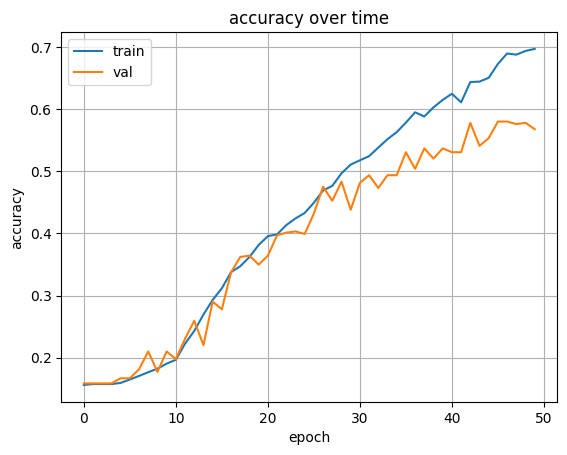

In [28]:
import matplotlib.pyplot as pyplot
    
def plotChange(history):
    pyplot.title('accuracy over time')
    pyplot.plot(history['accuracy'])
    pyplot.plot(history['val_accuracy'])
    pyplot.xlabel('epoch')
    pyplot.ylabel('accuracy')
    pyplot.legend(['train', 'val'], loc='upper left')
    pyplot.grid(True)
    pyplot.show()
        
    pyplot.show()
    
plotChange(sqlHistory.history)

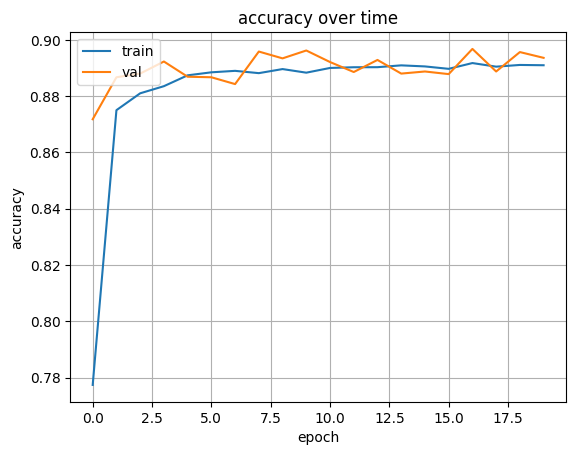

In [29]:
plotChange(tagHistory.history)

In [30]:
def getPredictions(finalStates):
    predictions = []
    for state in finalStates:
        predictions.append(tf.math.argmax(state).numpy())
    return predictions



In [31]:
tagPredictions = []
for example in tagVectorizedTestingText:
    tagPredictions.append(getPredictions(tagNNModel(np.array(example))))

sqlPredictions = getPredictions(sqlNNModel(np.array(vectorizedTestingText)))

In [32]:
def GetAccuracy(predictedValues, trueValues):
    total = 0
    true = 0
    i = 0
    while i < len(predictedValues):
        if(predictedValues[i] == trueValues[i]):
            true+=1
        total+=1
        i+=1
    return true/total

fullPredictedTemplate = formFullSqlTemplate(QuestionDatasets, QuestionDatasets.testingData['full-text'], sqlPredictions, tagPredictions)

fullTrueTemplate = formFullSqlTemplate(QuestionDatasets, QuestionDatasets.testingData['full-text'], QuestionDatasets.testingData['sql-id'], QuestionDatasets.testingData['tag-ids'])

GetAccuracy(fullTrueTemplate, fullPredictedTemplate)

447
447
447
447


0.12304250559284116

## LSTM

In [40]:


def GetLSTMModel(datasets: Datasets):
    numTags = len(tagToIdDictionary.keys())
    numClasses = len(datasets.sqlTemplateToIds.keys()) + 1

    # Model definition
    inputs = keras.Input(shape=(None,), dtype="int64")
    x = layers.Embedding(1000, EMBEDDING_DIMENSIONS, mask_zero=True)(inputs)
    #x = layers.GlobalAveragePooling1D()(x)
    x = layers.LSTM(128, return_sequences=True, dropout=.2)(x)
    lstm_out, state_h, _state_c = layers.LSTM(128, return_sequences=True, return_state=True, dropout=.2)(x)
    
    tagOutput = layers.Dense(numTags, activation='softmax', name="time_distributed")(lstm_out)
    template_output = layers.Dense(numClasses, activation='softmax', name="dense")(state_h)
    
    #x = layers.Dense(8, activation="relu")(x)
    #x = layers.Dropout(.5)(x)
    model = keras.Model(inputs=inputs, outputs=(tagOutput, template_output))
    # Compile the model
    model.compile(
        loss={
        "time_distributed": "sparse_categorical_crossentropy",
        "dense": "sparse_categorical_crossentropy"
        },  # adjust as needed,
        metrics=["accuracy", "accuracy"]
    )
    return model

In [34]:
def vectorizeAllText(dataset):
    return list(dataset['full-text'].map(vectorizeText))

def vectorizeText(text):
    return list(sqlVectorizationLayer(text))

def GetTagNumpyArray(dataset):
    result = []
    i = 0
    for ids in dataset['tag-ids']:
        length = len(ids)
        result.append(np.pad(ids, (0, 50-length)))
        i+=1
    
    return np.array(result)

trainingTagIdArray = GetTagNumpyArray(QuestionDatasets.trainingData)
trainingSqlIdArray = np.array(QuestionDatasets.trainingData['sql-id'])

validationTagIdArray = GetTagNumpyArray(QuestionDatasets.validationData)
validationSqlIdArray = np.array(QuestionDatasets.validationData['sql-id'])

testingTagIdArray = GetTagNumpyArray(QuestionDatasets.testingData)
testingSqlIdArray = np.array(QuestionDatasets.testingData['sql-id'])

In [41]:


LSTMModel = GetLSTMModel(QuestionDatasets)
history = LSTMModel.fit(x=np.array(vectorizedTrainingText), y=(trainingTagIdArray, trainingSqlIdArray), validation_data=(np.array(vectorizedValidationText), (validationTagIdArray, validationSqlIdArray)), epochs=100, batch_size=32)

Epoch 1/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - dense_accuracy: 0.1407 - dense_loss: 5.6986 - loss: 7.7791 - time_distributed_accuracy: 0.9049 - time_distributed_loss: 2.0805 - val_dense_accuracy: 0.1584 - val_dense_loss: 5.2956 - val_loss: 6.0948 - val_time_distributed_accuracy: 0.9426 - val_time_distributed_loss: 0.9829
Epoch 2/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - dense_accuracy: 0.1585 - dense_loss: 4.8839 - loss: 5.7898 - time_distributed_accuracy: 0.9134 - time_distributed_loss: 0.9059 - val_dense_accuracy: 0.1893 - val_dense_loss: 5.0971 - val_loss: 5.6606 - val_time_distributed_accuracy: 0.7445 - val_time_distributed_loss: 0.7190
Epoch 3/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - dense_accuracy: 0.1902 - dense_loss: 4.6628 - loss: 5.3135 - time_distributed_accuracy: 0.6537 - time_distributed_loss: 0.6507 - val_dense_accuracy: 0.2016 - val_dense_loss: 4.8270 - val_loss: 5.1922 - val_time_distributed_accuracy: 0.5319 - val_time_distributed_loss: 0.5618
Epo

In [86]:
import matplotlib.pyplot as pyplot

def plotLSTMChange(history, tagScale):
    pyplot.title('loss over time')
    pyplot.plot(history['dense_loss'])
    pyplot.plot(np.multiply(history['time_distributed_loss'], tagScale))
    pyplot.plot(history['val_dense_loss'])
    pyplot.plot(np.multiply(history['val_time_distributed_loss'], tagScale))
    pyplot.xlabel('epoch')
    pyplot.ylabel('loss')
    pyplot.legend(['template training', 'tag training', 'template val', 'tag val'], loc='upper left')
    pyplot.grid(True)
    pyplot.show()
        
    pyplot.show()

In [ ]:
plotLSTMChange(history.history, 10)

In [57]:
def printInfo(index):
    print(QuestionDatasets.testingData['tag-ids'][index])
    print(tagPredictions[index])
    print(fullPredictedTemplate[index])
    print(fullTrueTemplate[index])
    print(QuestionDatasets.testingData['full-text'][index])
    
    print(accuracy_score([fullPredictedTemplate[index]], [fullTrueTemplate[index]]))

predictions = LSTMModel.predict(np.array(vectorizedTestingText))
sqlPredictions = getPredictions(predictions[1])
print(predictions[0].shape)
tagPredictions = []
for example in predictions[0]:
    tagPredictions.append(getPredictions(example))
    
fullPredictedTemplate = formFullSqlTemplate(QuestionDatasets, QuestionDatasets.testingData['full-text'], sqlPredictions, tagPredictions)

fullTrueTemplate = formFullSqlTemplate(QuestionDatasets, QuestionDatasets.testingData['full-text'], QuestionDatasets.testingData['sql-id'], QuestionDatasets.testingData['tag-ids'])
printInfo(3)
accuracy_score(fullTrueTemplate, fullPredictedTemplate)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
(447, 50, 63)
447
447
447
447
[0, 0, 0, 6, 0, 2, 0, 0]
[0, 0, 0, 6, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
SELECT DISTINCT FLIGHTalias0.FLIGHT_ID FROM AIRLINE AS AIRLINEalias0 , AIRPORT_SERVICE AS AIRPORT_SERVICEalias0 , AIRPORT_SERVICE AS AIRPORT_SERVICEalias1 , CITY AS CITYalias0 , CITY AS CITYalias1 , DATE_DAY AS DATE_DAYalias0 , DAYS AS DAYSalias0 , FLIGHT AS FLIGHTalias0 WHERE ( ( DATE_DAYalias0.DAY_NUMBER = day_number0 AND DATE_DAYalias0.MONTH_NUMBER = month_number0 AND DATE_DAYalias0.YEAR = year0 AND DAYSalias0.DAY_NAME = DATE_DAYalias0.DAY_NAME AND FLIGHTalias0.AIRLINE_CODE = AIRLINEalias0.AIRLINE_CODE AND FLIGHTalias0.FLIGHT_DAYS = DAYSalias0.DAYS_CODE ) AND CITYalias1.CITY_CODE = AIRPORT_SERVICEalias1.CITY_CODE AND CITYalias1.CITY_NAME = MEMPHIS AND FLIGHTalias0.TO_AIRPORT = AIRPORT_SERVICEalias1.AIRPORT_CODE ) AND CITYalias0.CITY_CODE = A

0.26174496644295303

## Transformer

In [ ]:
# question split 

In [48]:
import keras
import tensorflow as tf
import numpy as np
from keras import layers

# Constants
MAX_FEATURES = 20000
MAX_SEQUENCE = 50
NUM_HEADS = 4
FF_DIM = 128

# define class, add mask attetion features inside, set hyperparameters
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        mask = self.compute_mask(inputs)
        attn_output = self.att(inputs, inputs, attention_mask=mask)
        out1 = self.layernorm1(inputs + self.dropout1(attn_output, training=training))
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + self.dropout2(ffn_output, training=training))
        return out2

# design transformer
def GetTransformer(datasets):
    numTags = len(tagToIdDictionary)
    numClasses = len(datasets.sqlTemplateToIds) + 1

    inputs = keras.Input(shape=(MAX_SEQUENCE,), dtype="int32")
    embedding_layer = layers.Embedding(MAX_FEATURES, EMBEDDING_DIMENSIONS, mask_zero=True)
    x = embedding_layer(inputs)

    transformer_block = TransformerBlock(EMBEDDING_DIMENSIONS, NUM_HEADS, FF_DIM)
    x = transformer_block(x, training=True)

    # Tag prediction branch (sequence labeling)
    tag_output = layers.Dense(numTags, activation="softmax", name="tag_output")(x)

    # SQL Template prediction branch (classification)
    global_avg_pool = layers.GlobalAveragePooling1D()(x)
    template_output = layers.Dense(numClasses, activation="softmax", name="template_output")(global_avg_pool)

    model = keras.Model(inputs=inputs, outputs=[tag_output, template_output])

    model.compile(
        optimizer="adam",
        loss={
            "tag_output": "sparse_categorical_crossentropy",
            "template_output": "sparse_categorical_crossentropy"
        },
        metrics={
            "tag_output": "accuracy",
            "template_output": "accuracy"
        }
    )

    return model
# evaluation metric
def GetAccuracy(predictedValues, trueValues):
    total = 0
    true = 0
    i = 0
    while i < len(predictedValues):
        if(predictedValues[i] == trueValues[i]):
            true+=1
        total+=1
        i+=1
    return true/total

# data padding
def pad_sequences_to_max_length(data, maxlen=MAX_SEQUENCE):
    return np.array([np.pad(ids, (0, maxlen - len(ids)))[:maxlen] for ids in data])

# pad 
trainingTagIdArray = pad_sequences_to_max_length(QuestionDatasets.trainingData['tag-ids'])
validationTagIdArray = pad_sequences_to_max_length(QuestionDatasets.validationData['tag-ids'])
testingTagIdArray = pad_sequences_to_max_length(QuestionDatasets.testingData['tag-ids'])
# get indices
trainingSqlIdArray = np.array(QuestionDatasets.trainingData['sql-id'])
validationSqlIdArray = np.array(QuestionDatasets.validationData['sql-id'])
testingSqlIdArray = np.array(QuestionDatasets.testingData['sql-id'])
# vectorize 
vectorizedTrainingText = np.array(vectorizedTrainingText)
vectorizedValidationText = np.array(vectorizedValidationText)
vectorizedTestingText = np.array(vectorizedTestingText)

# train model
transformer_model = GetTransformer(QuestionDatasets)

transformer_model.fit(
    x=vectorizedTrainingText,
    y={
        "tag_output": trainingTagIdArray,
        "template_output": trainingSqlIdArray
    },
    validation_data=(
        vectorizedValidationText, 
        {"tag_output": validationTagIdArray, "template_output": validationSqlIdArray}
    ),
    epochs=30,
    batch_size=64
)

# evaluate model
predictions = transformer_model.predict(vectorizedTestingText)
tagPredictions = np.argmax(predictions[0], axis=-1)
sqlPredictions = np.argmax(predictions[1], axis=-1)

# formulate sql templates
fullPredictedTemplate = formFullSqlTemplate(
    QuestionDatasets, 
    QuestionDatasets.testingData['full-text'], 
    sqlPredictions, 
    tagPredictions
)

fullTrueTemplate = formFullSqlTemplate(
    QuestionDatasets, 
    QuestionDatasets.testingData['full-text'], 
    testingSqlIdArray, 
    testingTagIdArray
)

printInfo(1)
accuracy = GetAccuracy(fullTrueTemplate, fullPredictedTemplate)
print(f"Transformer Question Split Accuracy: {accuracy:.4f}")

c:\Python311\Lib\site-packages\keras\src\layers\layer.py:1410: UserWarning: Layer 'transformer_block' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''Layer.compute_mask() missing 1 required positional argument: 'previous_mask'''
  warnings.warn(
c:\Python311\Lib\site-packages\keras\src\layers\layer.py:396: UserWarning: `build()` was called on layer 'transformer_block', however the layer does not have a `build()` method implemented and it looks like it has unb

TypeError: Exception encountered when calling TransformerBlock.call().

[1mCould not automatically infer the output shape / dtype of 'transformer_block' (of type TransformerBlock). Either the `TransformerBlock.call()` method is incorrect, or you need to implement the `TransformerBlock.compute_output_spec() / compute_output_shape()` method. Error encountered:

Layer.compute_mask() missing 1 required positional argument: 'previous_mask'[0m

Arguments received by TransformerBlock.call():
  • args=('<KerasTensor shape=(None, 50, 64), dtype=float32, sparse=False, ragged=False, name=keras_tensor_119>',)
  • kwargs={'training': 'True'}

using implementaion found here: https://medium.com/@max_garber/simple-keras-transformer-model-74724a83bb83

### Transformer

In [84]:
def GetDecoderBlock(input, encoder):
    NUM_HEADS = 3
    KEY_DIMENSION = 128
    feedForwardSize = 64
    
    query = keras.layers.Dense(EMBEDDING_DIMENSIONS)(input)
    value = keras.layers.Dense(EMBEDDING_DIMENSIONS)(input)
    key = keras.layers.Dense(EMBEDDING_DIMENSIONS)(input)

    attention = layers.MultiHeadAttention(num_heads=NUM_HEADS, key_dim=KEY_DIMENSION)(query, value, key, use_causal_mask=True)
    x = layers.Add()([input, attention])
    x = layers.LayerNormalization()(x)
    
    feedForwardOutput = layers.Dense(feedForwardSize, activation='relu')(x)
    x = layers.Add()([x, feedForwardOutput])
    x = layers.LayerNormalization()(x)
    
    query = keras.layers.Dense(EMBEDDING_DIMENSIONS)(x)
    value = keras.layers.Dense(EMBEDDING_DIMENSIONS)(encoder)
    key = keras.layers.Dense(EMBEDDING_DIMENSIONS)(encoder)
    
    attention = layers.MultiHeadAttention(num_heads=NUM_HEADS, key_dim=KEY_DIMENSION)(query, value, key)
    x = keras.layers.Add()([x , attention]) 
    x = keras.layers.LayerNormalization()(x)
    
    feedForwardOutput = layers.Dense(feedForwardSize, activation='relu')(x)
    x = layers.Add()([x, feedForwardOutput])
    return layers.LayerNormalization()(x)

def GetEncodingBlock(input):
    NUM_HEADS = 3
    KEY_DIMENSION = 128
    feedForwardSize = 64
    
    query = keras.layers.Dense(EMBEDDING_DIMENSIONS)(input)
    value = keras.layers.Dense(EMBEDDING_DIMENSIONS)(input)
    key = keras.layers.Dense(EMBEDDING_DIMENSIONS)(input)

    attention = layers.MultiHeadAttention(num_heads=NUM_HEADS, key_dim=KEY_DIMENSION)(query, value, key)
    x = layers.Add()([input, attention])
    x = layers.LayerNormalization()(x)
    
    feedForwardOutput = layers.Dense(feedForwardSize, activation='relu')(x)
    x = layers.Add()([x, feedForwardOutput])
    return layers.LayerNormalization()(x)

def GetTransformer(datasets): 

    OUTPUT_SIZE = 50
    
    numTags = len(tagToIdDictionary.keys())
    numClasses = len(datasets.sqlTemplateToIds.keys()) + 1

    # Model definition
    inputs = keras.Input(shape=(50,), dtype="int64")
    embeddings = layers.Embedding(1000, EMBEDDING_DIMENSIONS)(inputs)
    
    #positionalIndices = tf.range(OUTPUT_SIZE)
    
    #positionalEncodings = layers.Embedding(OUTPUT_SIZE, EMBEDDING_DIMENSIONS)(positionalIndices)
    #embeddings = layers.Add()([wordEmbeddings, positionalEncodings])
    
    x = GetEncodingBlock(embeddings)
    
    x = GetDecoderBlock(embeddings, x)
    
    tagOutput = layers.Dense(numTags, activation='softmax', name="time_distributed")(x)
    template_output = keras.layers.Lambda(lambda x: x[:,-1])(x)
    template_output = layers.Dense(numClasses, activation='softmax', name="dense")(template_output)
    
    #x = layers.GlobalAveragePooling1D()(x)


    model = keras.Model(inputs=inputs, outputs=(tagOutput, template_output))
    # Compile the model
    model.compile(
        loss={
        "time_distributed": "sparse_categorical_crossentropy",
        "dense": "sparse_categorical_crossentropy"
        },
        metrics=["accuracy", "accuracy"],
        loss_weights= {"time_distributed": 100,
        "dense": 1}
    )
    return model

In [90]:
transformerModel = GetTransformer(QueryDatasets)
print(np.array(vectorizedTestingText).shape)
predictions = transformerModel.predict(np.array(vectorizedTestingText))
print(predictions[1].shape)
history = transformerModel.fit(x=np.array(vectorizedTrainingText), y=(trainingTagIdArray, trainingSqlIdArray), validation_data=(np.array(vectorizedTestingText), (testingTagIdArray, testingSqlIdArray)), epochs=13, batch_size=32)

(447, 50)
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
(447, 828)
Epoch 1/13
136/136 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - dense_accuracy: 0.1156 - dense_loss: 5.8200 - loss: 36.7067 - time_distributed_accuracy: 0.9245 - time_distributed_loss: 0.3089 - val_dense_accuracy: 0.1611 - val_dense_loss: 6.1071 - val_loss: 12.2060 - val_time_distributed_accuracy: 0.9747 - val_time_distributed_loss: 0.0612
Epoch 2/13
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - dense_accuracy: 0.1538 - dense_loss: 5.0257 - loss: 10.2531 - time_distributed_accuracy: 0.9750 - time_distributed_loss: 0.0523 - val_dense_accuracy: 0.2237 - val_dense_loss: 5.7494 - val_loss: 10.7564 - val_time_distributed_accuracy: 0.9765 - val_time_distributed_loss: 0.0502
Epoch 3/13
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - dense_accuracy: 0.2977 - dense_loss: 4.3850 - loss: 8.5918 - time_distributed_accuracy: 0.9799 - time_distributed_loss: 0.0421 - val_dense_accuracy: 0.3110 - val_dense_loss: 5.2823 - val_loss: 9.8390 - val_time_distri

In [91]:
predictions = transformerModel.predict(np.array(vectorizedTestingText))
sqlPredictions = getPredictions(predictions[1])
print(predictions[0].shape)
tagPredictions = []
for example in predictions[0]:
    tagPredictions.append(getPredictions(example))
    
fullPredictedTemplate = formFullSqlTemplate(QuestionDatasets, QuestionDatasets.testingData['full-text'], sqlPredictions, tagPredictions)

fullTrueTemplate = formFullSqlTemplate(QuestionDatasets, QuestionDatasets.testingData['full-text'], QuestionDatasets.testingData['sql-id'], QuestionDatasets.testingData['tag-ids'])
printInfo(3)
accuracy_score(fullTrueTemplate, fullPredictedTemplate)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
(447, 50, 63)
447
447
447
447
[0, 0, 0, 6, 0, 2, 0, 0]
[0, 0, 0, 6, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
SELECT DISTINCT FLIGHTalias0.FLIGHT_ID FROM AIRLINE AS AIRLINEalias0 , AIRPORT_SERVICE AS AIRPORT_SERVICEalias0 , AIRPORT_SERVICE AS AIRPORT_SERVICEalias1 , CITY AS CITYalias0 , CITY AS CITYalias1 , DATE_DAY AS DATE_DAYalias0 , DAYS AS DAYSalias0 , FLIGHT AS FLIGHTalias0 WHERE ( ( DATE_DAYalias0.DAY_NUMBER = day_number0 AND DATE_DAYalias0.MONTH_NUMBER = month_number0 AND DATE_DAYalias0.YEAR = year0 AND DAYSalias0.DAY_NAME = DATE_DAYalias0.DAY_NAME AND FLIGHTalias0.AIRLINE_CODE = AIRLINEalias0.AIRLINE_CODE AND FLIGHTalias0.FLIGHT_DAYS = DAYSalias0.DAYS_CODE ) AND CITYalias1.CITY_CODE = AIRPORT_SERVICEalias1.CITY_CODE AND CITYalias1.CITY_NAME = MEMPHIS AND FLIGHTalias0.TO_AIRPORT = AIRPORT_SERVICEalias1.AIRPORT_CODE ) AND CITYalias0.CITY_CODE = A

0.4004474272930649

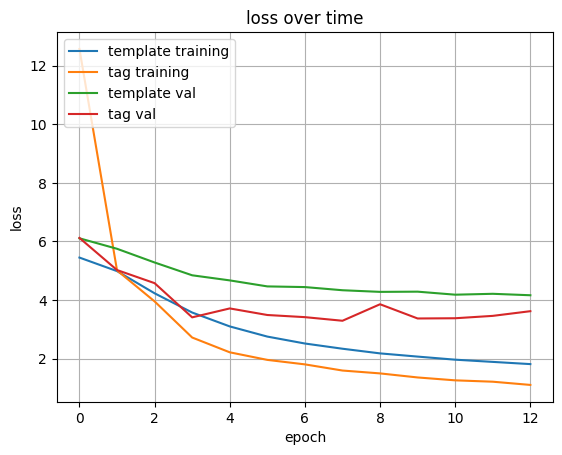

In [92]:
plotLSTMChange(history.history, 100)

28% with average pool
seems to converge after 20 epochs
4.8 val loss on template
.06 val loss on sequential

38% with lambdas layer and 100x loss weight on tags